In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

In [4]:
data_mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X_mnist = data_mnist.data
y_mnist = data_mnist.target



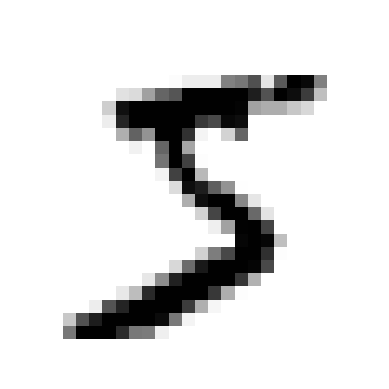

Label: 5


In [5]:
import matplotlib.pyplot as plt

def show_number(index):
    some_digit = X_mnist[index].reshape(28, 28)
    plt.imshow(some_digit, cmap=plt.cm.binary)
    plt.axis("off")
    plt.show()
    print("Label:", y_mnist[index])

show_number(0)

In [6]:
X_train, X_valid, X_test = X_mnist[:50000], X_mnist[50000:60000], X_mnist[60000:]
y_train, y_valid, y_test = y_mnist[:50000], y_mnist[50000:60000], y_mnist[60000:]

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_train_scaled)

In [8]:
sgd_clf = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)
dec_tree_clf = DecisionTreeClassifier(max_depth=20, random_state=42)
rnd_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [9]:
estimators= [sgd_clf, dec_tree_clf, rnd_forest_clf]
for i in estimators:
    print(f"Training {i.__class__.__name__}...")
    i.fit(X_train, y_train)

Training SGDClassifier...
Training DecisionTreeClassifier...
Training RandomForestClassifier...


In [10]:
[i.score(X_valid, y_valid) for i in estimators]

[0.8739, 0.8865, 0.9736]

In [11]:
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ('sgd_clf', sgd_clf),
    ('decision_tree', dec_tree_clf),
    ('random_forest', rnd_forest_clf)
]
voting_clf = VotingClassifier(estimators=named_estimators, voting='hard')
voting_clf.fit(X_train, y_train)
voting_clf.score(X_valid, y_valid)

0.9551

In [12]:
y_valid_encoded = y_valid.astype(np.int64)
[i.score(X_valid, y_valid_encoded) for i in voting_clf.estimators_]

[0.8739, 0.8865, 0.9736]

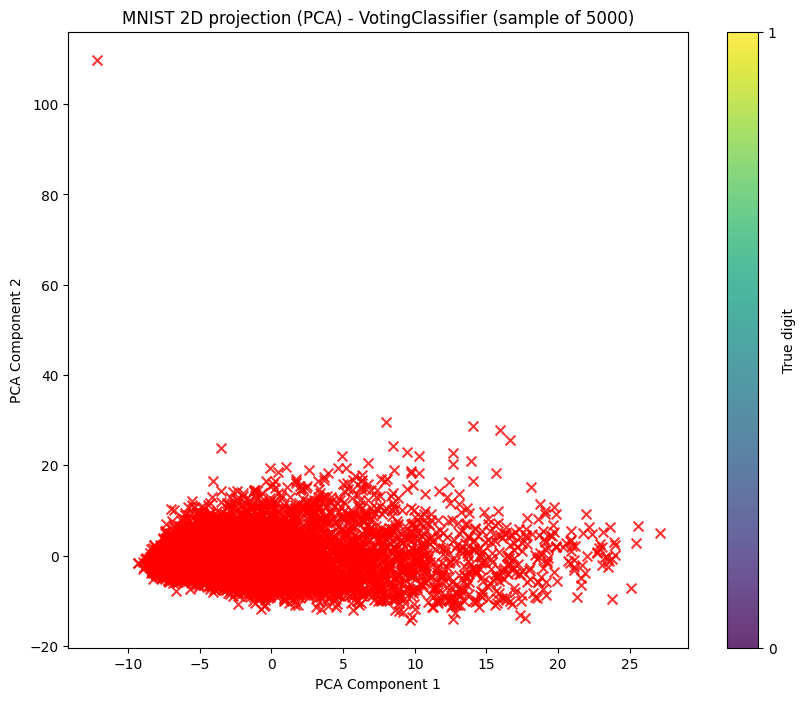

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Подвыборка для графика (чтобы Colab не тормозил)
sample_size = 5000
X_plot_sample = X_train_scaled[:sample_size]  # используем масштабированные данные
y_plot_sample = y_train.astype(int)[:sample_size]
y_pred_sample = voting_clf.predict(X_plot_sample)

# Снижаем размерность до 2D через PCA
pca = PCA(n_components=2)
X_2d_sample = pca.fit_transform(X_plot_sample)

plt.figure(figsize=(10, 8))

for true_label in np.unique(y_plot_sample):
    mask = y_plot_sample == true_label
    correct_mask = (y_pred_sample == y_plot_sample) & mask
    wrong_mask = (y_pred_sample != y_plot_sample) & mask

    # Правильно предсказанные — маленькие кружки
    plt.scatter(X_2d_sample[correct_mask, 0], X_2d_sample[correct_mask, 1],
                c=[true_label]*sum(correct_mask), cmap='tab10',
                marker='o', s=15, edgecolor='k', alpha=0.6)

    # Ошибки — большие крестики красным цветом
    plt.scatter(X_2d_sample[wrong_mask, 0], X_2d_sample[wrong_mask, 1],
                c='red', marker='x', s=50, alpha=0.8)

plt.colorbar(ticks=range(10), label='True digit')
plt.title("MNIST 2D projection (PCA) - VotingClassifier (sample of 5000)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()
